# Modeling

In [266]:
# basic data and viz libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# modeling libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [267]:
df = pd.read_csv('ExpandedScoresData_Engineered.csv')
# print shape and check columns from last notebook
print("Shape:", df.shape)
print("\nFeatures:", df.drop('avg_score', axis=1).columns.tolist())

Shape: (30641, 22)

Features: ['gender', 'ethnicity', 'parental_education', 'lunch_type', 'test_prep', 'parent_marital_status', 'practice_sports', 'first_child', 'num_siblings', 'transport_means', 'weekly_study_hours', 'math_score', 'reading_score', 'writing_score', 'parent_ed_ordinal', 'study_hours_ordinal', 'ses_proxy', 'effort_level', 'math_writing_gap', 'math_reading_gap', 'perf_tier']


In [268]:
# define the feature columns by dropping the target column
feature_cols = df.columns.drop('avg_score').tolist()

# separate numeric columns
numeric_features = [
    'parent_ed_ordinal',
    'study_hours_ordinal',
    'num_siblings',
    'math_writing_gap',
    'math_reading_gap'
]

categorical_features = [
    'gender',
    'ethnicity',
    'parental_education',
    'lunch_type',
    'test_prep',
    'weekly_study_hours',
    'practice_sports',
    'effort_level'
]

print(f"Numeric: {len(numeric_features)}")
print(f"Categorical: {len(categorical_features)}")

feature_cols_reduced = [col for col in feature_cols if col != 'ses_proxy']  

# define X and y for train test split
X = df[feature_cols_reduced]
y = df['avg_score']

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Numeric: 5
Categorical: 8
Train: (24512, 20), Test: (6129, 20)


In [269]:
# one-hot encoding for linear regression
encoder = OneHotEncoder (sparse_output=False, drop='first', handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train[categorical_features])
X_test_encoded = encoder.transform(X_test[categorical_features])

# combine encoded categorical features with numeric features
X_train_final = np.hstack([X_train_encoded, X_train[numeric_features].values])
X_test_final = np.hstack([X_test_encoded, X_test[numeric_features].values])

# After encoding, get the feature names
encoded_cat_names = encoder.get_feature_names_out(categorical_features)
all_feature_names = list(encoded_cat_names) + numeric_features


In [270]:
# fit the model
lr_model = LinearRegression()
lr_model.fit(X_train_final, y_train)

print("Linear Regression Results:")
print(f"Train R²: {r2_score(y_train, lr_model.predict(X_train_final)):.3f}")
print(f"Test R²: {r2_score(y_test, lr_model.predict(X_test_final)):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, lr_model.predict(X_test_final))):.2f}")

Linear Regression Results:
Train R²: 0.261
Test R²: 0.263
Test RMSE: 12.32


The linear regression model explains about 26% of the variation in average student scores and typically predicts within about 12-13 points of the true score on held-out data, with nearly identical performance on train and test sets. 

In [271]:
# ridge regression for handling multicollinearity
from sklearn.linear_model import Ridge, RidgeCV

ridge_cv = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=5)
ridge_cv.fit(X_train_final, y_train)
print(f"\nBest alpha: {ridge_cv.alpha_}")


Best alpha: 10.0


In [272]:
ridge_model = Ridge(alpha=ridge_cv.alpha_)
ridge_model.fit(X_train_final, y_train)

print("\nRidge Regression Results:")
print(f"Test R²: {r2_score(y_test, ridge_model.predict(X_test_final)):.3f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, ridge_model.predict(X_test_final))):.2f}")


Ridge Regression Results:
Test R²: 0.263
Test RMSE: 12.32


In [273]:
# Compare coefficients
coef_comparison = pd.DataFrame({
    'feature': all_feature_names,
    'linear_coef': lr_model.coef_,
    'ridge_coef': ridge_model.coef_
})
print("\nCoefficient Stability:")
print(coef_comparison.head(10))


Coefficient Stability:
                                feature  linear_coef  ridge_coef
0                           gender_male    -3.582080   -3.572042
1                     ethnicity_group B     0.624045    0.516836
2                     ethnicity_group C     1.741186    1.633310
3                     ethnicity_group D     5.006602    4.890109
4                     ethnicity_group E     9.317596    9.183318
5                     ethnicity_unknown     2.576277    2.454040
6  parental_education_bachelor's degree     1.036453    1.023097
7        parental_education_high school    -1.467931   -1.465709
8    parental_education_master's degree     2.533610    2.507740
9       parental_education_some college    -0.633039   -0.635909


### Feature Selection and Target Leakage Prevention

**Important:** This model predicts average test scores using ONLY demographic and 
behavioral factors (parental education, lunch type, study hours, etc.). Individual 
test scores (math, reading, writing) were intentionally excluded because avg_score 
is computed as their average - including them would constitute target leakage.

### Ridge vs Linear Regression Comparison

As seen above, Ridge and Linear regression achieve nearly identical performance 
(both R² = 0.263, RMSE = 12.32). A Ridge model was included to assess whether 
multicollinearity was affecting coefficient stability.

**Key observations:**
- Both models perform identically, indicating no severe multicollinearity issues
- Feature correlations are at healthy levels after removing redundant variables
- Coefficients remain stable without regularization
- Ridge's penalty adds complexity without improving predictions

**Changes from earlier versions:**
- Removed `ses_proxy` (redundant with lunch_type and parental_education)
- Removed `perf_tier` (derived from the target variable)
- These changes improved model validity while maintaining interpretability

### Interpreting R² = 0.263

The R² of 0.263 indicates that demographic factors explain roughly one-quarter 
of score variation. This aligns with educational research showing that while 
socioeconomic factors influence outcomes, they don't determine them - individual 
effort, instructional quality, prior knowledge, and innate aptitude play major roles.

While this R² may seem modest compared to typical machine learning benchmarks 
(where R² > 0.8 is often expected), it's realistic and meaningful for social 
science applications. The model successfully captures broad demographic patterns 
that can inform:
- Resource allocation decisions
- Early intervention program targeting
- Understanding equity gaps in educational outcomes

**Conclusion:** Standard Linear Regression is the optimal choice for this dataset, 
as Ridge's regularization provides no additional benefit.

# Binary Classification for at risk students

In [274]:
threshold = 60
# splitting train and test individually to avoid data leakage. the split was already conducted for linear/ridge regression
y_train_clf = (y_train < threshold).astype(int)
y_test_clf = (y_test < threshold).astype(int)

print(f"{y_train_clf.sum()} training students ({y_train_clf.mean():.1%}) are at-risk")
print(f"{y_test_clf.sum()} test students ({y_test_clf.mean():.1%}) are at-risk")

#reusing the encoder created for linear/rideg regression
X_train_clf_final = X_train_final 
X_test_clf_final = X_test_final 


7072 training students (28.9%) are at-risk
1686 test students (27.5%) are at-risk


In [275]:
# Logistic regression
logit_model = LogisticRegression(max_iter=1000, random_state=42)
logit_model.fit(X_train_clf_final, y_train_clf)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [276]:
# Predict
y_pred_clf = logit_model.predict(X_test_clf_final)
y_proba_clf = logit_model.predict_proba(X_test_clf_final)[:, 1]

In [277]:
# Evaluate
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

print("\nBinary Classification Results (At-Risk Prediction):")
print(classification_report(y_test_clf, y_pred_clf, 
                           target_names=['Not At-Risk', 'At-Risk']))
print(f"ROC-AUC: {roc_auc_score(y_test_clf, y_proba_clf):.3f}")


Binary Classification Results (At-Risk Prediction):
              precision    recall  f1-score   support

 Not At-Risk       0.78      0.92      0.84      4443
     At-Risk       0.59      0.32      0.41      1686

    accuracy                           0.75      6129
   macro avg       0.69      0.62      0.63      6129
weighted avg       0.73      0.75      0.72      6129

ROC-AUC: 0.737


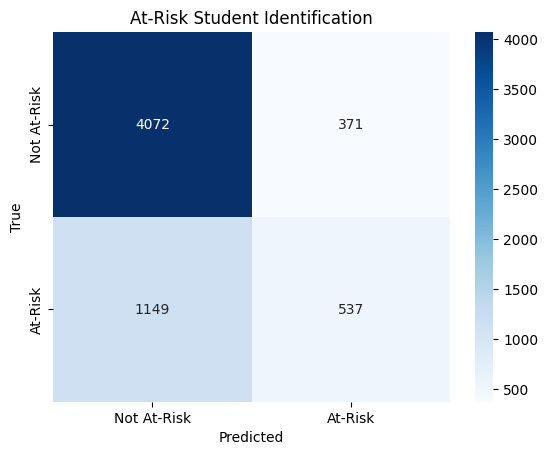

In [278]:
# Confusion matrix
cm = confusion_matrix(y_test_clf, y_pred_clf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Not At-Risk', 'At-Risk'],
           yticklabels=['Not At-Risk', 'At-Risk'])
plt.title('At-Risk Student Identification')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

## Key Findings

### Regression Model Performance (R² = 0.263)

The linear regression model explains 26.3% of variance in student test scores 
using only demographic and behavioral features (lunch type, parental education, 
study hours, etc.). Individual test scores (math, reading, writing) were 
intentionally excluded to avoid target leakage.

**What this means:**
- Demographic factors explain roughly 1/4 of academic performance
- The remaining 3/4 is explained by other factors: prior knowledge, instructional 
  quality, individual aptitude, motivation, etc.
- This is consistent with educational research showing that while socioeconomic 
  status matters, it's not destiny

**Practical implications:**
- RMSE of 12.3 points means predictions are useful for broad risk categories
- Not precise enough for high-stakes individual decisions
- Most valuable for identifying groups that may need additional support

### Classification Model Performance (75% accuracy)

The logistic regression model achieves 75% accuracy in identifying at-risk 
students (score < 60) using the same demographic features.

**Key metrics:**
- 92% recall for not-at-risk students (correctly identifies most safe students)
- 32% recall for at-risk students (catches 1/3 of struggling students)
- ROC-AUC of 0.737 indicates good discrimination

This suggests the model is conservative - it has low false positives (rarely 
flags safe students as at-risk) but misses some at-risk students. For an 
early warning system, this could be tuned based on resource constraints.